# Amazon Product Reviews: Text and sentiment Analysis

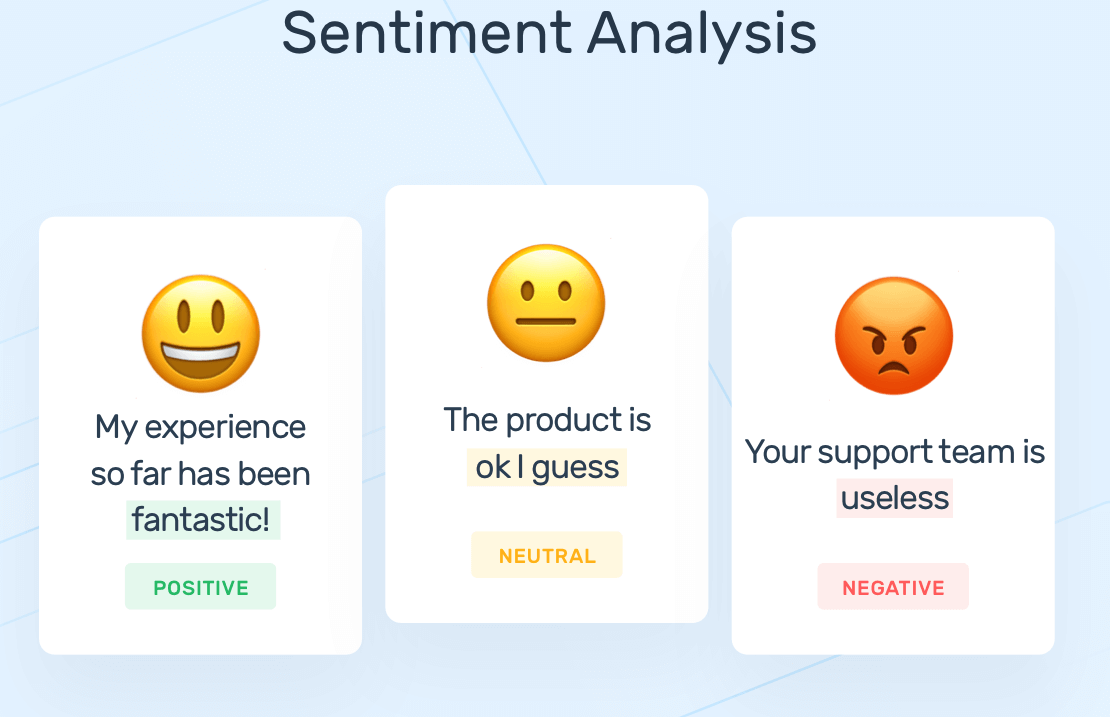

**Objective**:
The objective of this project is to gather product reviews for Apple MacBook from Amazon through web scraping. After collecting the reviews, we will conduct text analysis and visualization to gain insights into customer opinions and preferences. In addition, we will be implementing BERT model for sentiment analysis, where reviews with a rating of more than 3 will be considered positive, and the rest will be classified as negative. The goal is to predict a comprehensive understanding of the sentiments associated with Apple MacBook review.


In [ ]:
! pip install requests 
! pip install bs4
! pip install clean-text
! pip install transformers

In [25]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import cleantext
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from transformers import BertTokenizer, TFBertModel,TFBertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Web scraping the data

To achieve this, I utilized the Splash Docker to render the Amazon website into an HTML page. After running the Docker locally, I accessed the HTML page endpoint to extract the data using Beautiful Soup.

*The above code cell will not run in colab notebook because colab cannot hit the docker conatiner running in local system.Hence, I am adding separate python script for scraping while submission*

In [ ]:
reviewlist = []

def get_soup(url):
    r = requests.get('http://localhost:8050/render.html', params={'url': url, 'wait': 2})
    soup = bs(r.text, 'html.parser')
    return soup


def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
            'product': soup.title.text.replace('Amazon.com:Customer reviews:', '').strip(),
            'title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
            'date': soup.find('span', {'data-hook': 'review-date'}).text.strip(),
            'rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
            'body': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            }
            reviewlist.append(review)
    except:
        pass

for x in range(1,400):
    soup = get_soup(f"https://www.amazon.com/Apple-MacBook-13-inch-256GB-Storage/product-reviews/B08N5LNQCX/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber={x}")
    print(f'Getting page: {x}')
    get_reviews(soup)
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

df = pd.DataFrame(reviewlist)
df.to_csv('product_review.csv', index=False)


# Test preprocessing and Cleaning

I am performing following steps of text cleaning and processing:


1.   Removing rows if it has missing values
2.   Removing stopwords. Stopwords are those words which occur very frequently but are not required for analysis as they provide no insights. Removing them will reduce computational load. They include words like I, me, myself, that, him, etc.
3. Removing emojis
4. Removing punctuations and extra spaces





In [2]:
df=pd.read_csv("/content/product_review.csv")

In [3]:
df

,product,title,date,rating,body
0,Amazon.com: Customer reviews: Apple 2020 MacBo...,"Great battery life, great performance!","Reviewed in the United States on December 6, 2022",5.0,UPDATE 3/8/2023: i bought parallels desktop an...
1,Amazon.com: Customer reviews: Apple 2020 MacBo...,"Very lightweight, good speed, but NOT gold at all","Reviewed in the United States on December 6, 2022",4.0,Updated review with more detail [after 2 weeks...
2,Amazon.com: Customer reviews: Apple 2020 MacBo...,Great notebook with almost no weaknesses,"Reviewed in the United States on December 6, 2022",5.0,Why is it that the PC world cannot make a good...
3,Amazon.com: Customer reviews: Apple 2020 MacBo...,The best device for work and travel,"Reviewed in the United States on December 6, 2022",5.0,"As a programmer, I can say that this is just t..."
4,Amazon.com: Customer reviews: Apple 2020 MacBo...,Finally able to move to a mac,"Reviewed in the United States on December 6, 2022",5.0,I have tried for years to move to a mac given ...
...,...,...,...,...,...
1695,Amazon.com: Customer reviews: Apple 2020 MacBo...,"Grandma wants, grandma gets",Reviewed in the United States 🇺🇸 on September ...,5.0,My grandmother’s birthday falls on Christmas D...
1696,Amazon.com: Customer reviews: Apple 2020 MacBo...,Amazing,Reviewed in the United States 🇺🇸 on September ...,5.0,"Works great, no issues"
1697,Amazon.com: Customer reviews: Apple 2020 MacBo...,Loved it,Reviewed in the United States 🇺🇸 on September ...,5.0,Just simply loving it.
1698,Amazon.com: Customer reviews: Apple 2020 MacBo...,The most beautiful Mac book ever,Reviewed in the United States 🇺🇸 on September ...,5.0,The Mac book air M1 is powerful. The color is ...


In [4]:
df['product']="Apple Macbook M1"

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   product  1700 non-null   object 
 1   title    1700 non-null   object 
 2   date     1700 non-null   object 
 3   rating   1700 non-null   float64
 4   body     1689 non-null   object 
dtypes: float64(1), object(4)
memory usage: 66.5+ KB


In [6]:
df.isnull().sum()

product     0
title       0
date        0
rating      0
body       11
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

product    0
title      0
date       0
rating     0
body       0
dtype: int64

In [9]:
def text_cleaning(text):
  text=text.lower()
  stop = stopwords.words('english')
  text = " ".join([word for word in text.split() if word not in stop])
  text=cleantext.clean(text, no_emoji=True)
  translator = str.maketrans('', '', string.punctuation)
  text=text.translate(translator)
  return text



In [10]:
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)
df['title'] = df['title'].apply(text_cleaning)
df['body'] = df['body'].apply(text_cleaning) 


In [11]:
df.shape

(1689, 5)

In [12]:
df[df['rating']>3].shape

(1416, 5)

In [13]:
df

,product,title,date,rating,body
0,Apple Macbook M1,great battery life great performance,"Reviewed in the United States on December 6, 2022",5.0,update 382023 bought parallels desktop windows...
1,Apple Macbook M1,lightweight good speed gold,"Reviewed in the United States on December 6, 2022",4.0,updated review detail after 2 weeks see addit...
2,Apple Macbook M1,great notebook almost weaknesses,"Reviewed in the United States on December 6, 2022",5.0,pc world cannot make good notebook price macbo...
3,Apple Macbook M1,best device work travel,"Reviewed in the United States on December 6, 2022",5.0,programmer say perfect device work battery las...
4,Apple Macbook M1,finally able move mac,"Reviewed in the United States on December 6, 2022",5.0,tried years move mac given use iphone ipad how...
...,...,...,...,...,...
1695,Apple Macbook M1,grandma wants grandma gets,Reviewed in the United States 🇺🇸 on September ...,5.0,grandmothers birthday falls christmas day pret...
1696,Apple Macbook M1,amazing,Reviewed in the United States 🇺🇸 on September ...,5.0,works great issues
1697,Apple Macbook M1,loved,Reviewed in the United States 🇺🇸 on September ...,5.0,simply loving it
1698,Apple Macbook M1,beautiful mac book ever,Reviewed in the United States 🇺🇸 on September ...,5.0,mac book air m1 powerful color stunning better...


In [14]:
from datetime import datetime
def return_dt(ex_string):
  date = datetime.strptime(ex_string.split("on ")[1], "%B %d, %Y").date()
  return date

df['date'] = df['date'].apply(return_dt)


In [15]:
df['date']=pd.to_datetime(df['date'])

In [16]:
df.dtypes

product            object
title              object
date       datetime64[ns]
rating            float64
body               object
dtype: object

# Data visualization

#### Laptop rating plotted over the years from 2020-2023

<Axes: xlabel='date', ylabel='count'>

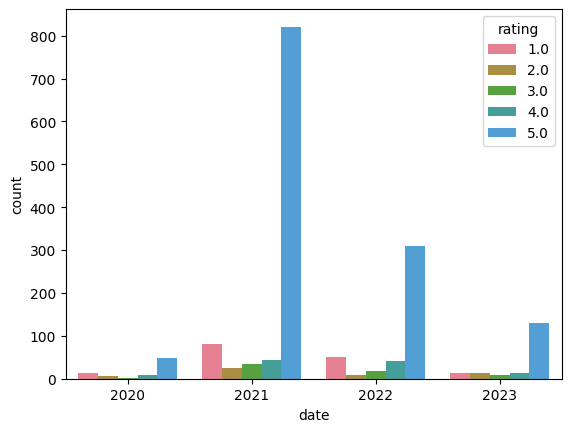

In [27]:
sns.set_palette("husl")
sns.countplot(data=df, x=df["date"].dt.year, hue="rating")


#### Frequent words in Positive Reviews

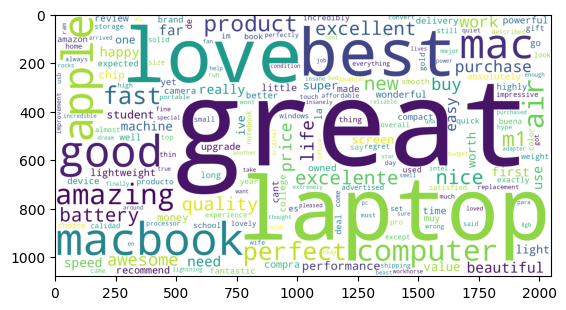

In [29]:
text1 = " ".join(title for title in df[df.rating>3.0].title)
word_cloud1 = WordCloud(collocations = False, background_color = 'white', width = 2048, height = 1080).generate(text1)
plt.imshow(word_cloud1)


#### Frequent words in Negative reviews

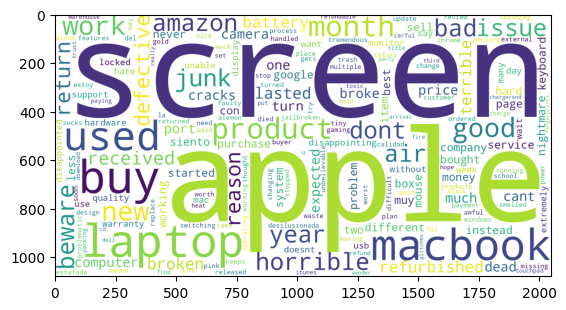

In [30]:
text2 = " ".join(title for title in df[df.rating<2.0].title)
word_cloud2 = WordCloud(collocations = False, background_color = 'white', width = 2048, height = 1080).generate(text2)
plt.imshow(word_cloud2)


# Data splitting for model training

Converting rating in binary: 3+ ratings are positive and remaining negative

I have implemented bert model which will predict the test dataset reviews will be positive or negative.

In [31]:
df['rating'] = df['rating'].apply(lambda x: int(x > 3))

In [32]:
X = df["title"]
y = df["rating"]

In [33]:
df.dtypes

product            object
title              object
date       datetime64[ns]
rating              int64
body               object
dtype: object

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2 ,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2 ,random_state=0)

In [36]:
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')


In [37]:
X_train=X_train.to_list()
X_val=X_val.to_list()
X_test=X_test.to_list()

print(len(X_train),len(X_test),len(X_val))

1080 338 271


In [38]:
train_encodings= tokenizer(X_train, truncation=True,padding=True)
val_encodings= tokenizer(X_val, truncation=True,padding=True)
test_encodings= tokenizer(X_test, truncation=True,padding=True)


In [39]:

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))


In [40]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(64)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(train_dataset, epochs=2, validation_data=val_dataset)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
68/68 [==============================] - 505s 7s/step - loss: 0.3924 - accuracy: 0.8509 - val_loss: 0.3717 - val_accuracy: 0.8413
Epoch 2/2
68/68 [==============================] - 412s 6s/step - loss: 0.2292 - accuracy: 0.9111 - val_loss: 0.3888 - val_accuracy: 0.8598


In [41]:
test_dataset = test_dataset.batch(64)
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


6/6 [==============================] - 47s 6s/step - loss: 0.3756 - accuracy: 0.8491
Test Loss: 0.3755779266357422
Test Accuracy: 0.8491124510765076


Accuracy of the model on test dataset is 84.9%

In [42]:
predictions = model.predict(test_dataset)


6/6 [==============================] - 31s 3s/step


In [43]:
tf_prediction = tf.nn.softmax(predictions[0], axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()


Printing the predicted labels for test dataset

In [44]:
print(label)


[1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1]


<Axes: >

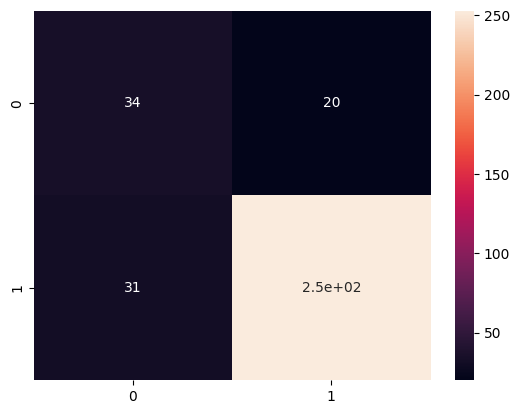

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=label)
sns.heatmap(confusion_matrix, annot=True)


Confusion matrix shows that the False postives and False negatives are much smaller compared to True positive and True Negative

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, label))


              precision    recall  f1-score   support

           0       0.52      0.63      0.57        54
           1       0.93      0.89      0.91       284

    accuracy                           0.85       338
   macro avg       0.72      0.76      0.74       338
weighted avg       0.86      0.85      0.85       338

